In [2]:
import os
root_proj = '/home/xin/Desktop/developer-luo/Glacier-in-SETP'
os.chdir(root_proj)


In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
import xarray as xr
from utils.geotif_io import readTiff 
import numpy as np
from osgeo import ogr, gdal
from utils.transform_xy import geo2imagexy



In [3]:
path_cm051_tm = 'data/CN05-Climate-Data/Monthly/CN05.1_Tm_1961_2021_monthly_025x025.nc'
path_setp_vec = 'data/boundary/setp_zhao2022.gpkg'


In [4]:
ds = xr.open_dataset(path_cm051_tm)
# ds



### Subseting for the cn05 data

In [5]:
ds_subs = ds.sel(lat=slice(27, 32), lon=slice(91, 99), time=slice('2000-01-01','2021-12-31'))
ds_subs


<xarray.Dataset>
Dimensions:    (time: 264, bnds: 2, lon: 33, lat: 21)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-16 2000-02-15 ... 2021-12-16
  * lon        (lon) float64 91.0 91.25 91.5 91.75 ... 98.25 98.5 98.75 99.0
  * lat        (lat) float64 27.0 27.25 27.5 27.75 ... 31.25 31.5 31.75 32.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    tm         (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.9rc1 (https://mpimet.mpg...
    Conventions:  CF-1.4
    history:      Thu Mar 03 15:23:52 2022: cdo monmean CN05.1_Tm_1961_2021_d...
    frequency:    mon
    CDO:          Climate Data Operators version 1.9.9rc1 (https://mpimet.mpg...

### Full Data 

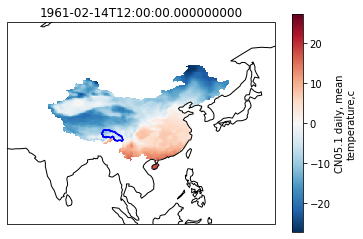

In [6]:
id_date = 1
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([60, 150, 0, 60])
ds['tm'][id_date].plot(x='lon',y='lat', ax=ax)
plt.title(ds['time'][id_date].values)
## 1. Tibeteau southeast boundary
shp_fea = cfeature.ShapelyFeature(Reader(path_setp_vec).geometries(), \
                      crs=ccrs.PlateCarree(), edgecolor='blue', linewidth=1.5, facecolor='none')
ax.add_feature(shp_fea, zorder=1)


### SETP region

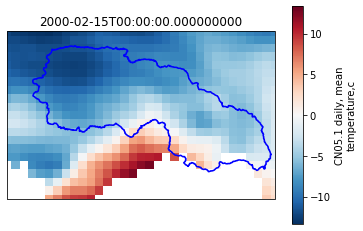

In [7]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([91, 99, 27, 32])   # setp region
ds_subs['tm'][1].plot(x='lon',y='lat', ax=ax)
plt.title(ds_subs['time'][id_date].values)
## 1. Tibeteau southeast boundary
shp_fea = cfeature.ShapelyFeature(Reader(path_setp_vec).geometries(), \
                      crs=ccrs.PlateCarree(), edgecolor='blue', linewidth=1.5, facecolor='none')
ax.add_feature(shp_fea, zorder=1)


### Data mask by .shp file

In [8]:
### shp to raster
input_shp = ogr.Open(path_setp_vec)
shp_layer = input_shp.GetLayer()
geoextent=[91, 99, 27, 32]
geotrans = (91, 0.25, 0.0, 32, 0.0, -0.25)
# geotrans = (91, 0.125, 0.0, 32, 0.0, -0.125)
geoproj = '4326'
x_res, y_res = ds_subs['lon'].shape[0], ds_subs['lat'].shape[0]
# x_res, y_res = ds_subs['lon'].shape[0]*2, ds_subs['lat'].shape[0]*2
drv = gdal.GetDriverByName('MEM')
targetData = drv.Create('', x_res, y_res, 1, gdal.GDT_Byte)
targetData.SetGeoTransform(geotrans)
targetData.SetProjection(geoproj)
band = targetData.GetRasterBand(1)
NoData_value = -9999
band.SetNoDataValue(NoData_value)
band.FlushCache()
gdal.RasterizeLayer(targetData, [1], shp_layer, burn_values=[1])
mask = targetData.ReadAsArray(0, 0, x_res, y_res)
mask = np.where(mask>0, 1, 0)
mask.shape


(21, 33)

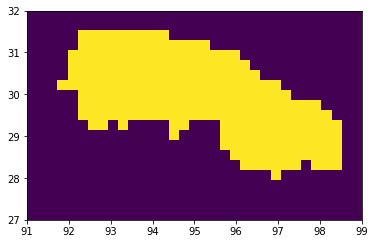

In [9]:
plt.imshow(mask , vmax=1, vmin=0, extent=geoextent)


### Apply the mask to the .nc data.

#### 1. Find the positions to be masked

In [10]:
lats, lons = ds_subs['lat'].values, ds_subs['lon'].values
lats_map = np.expand_dims(lats, axis=1)     # 1d -> 2d
lats_map = np.repeat(lats_map, lons.shape[0], 1)  # 
lons_map = np.expand_dims(lons, axis=0)     # 1d -> 2d
lons_map = np.repeat(lons_map, lats.shape[0], 0)  
lats_all = lats_map.flatten()
lons_all = lons_map.flatten()
print(lats_all.shape, lons_all.shape)


(693,) (693,)


In [21]:
## wgs84 coords to image coords
row_img, col_img = geo2imagexy(x=lons_all, y=lats_all, gdal_trans=geotrans, integer=True)
print('overall positions:', row_img.shape[0])
## find the wgs84 coords which should be masked.
ids_mask = np.where(mask[row_img, col_img] == 0)[0]
lons_mask, lats_mask = lons_all[ids_mask], lats_all[ids_mask]
print('positions should be masked:', lons_mask.shape[0])


overall positions: 693
positions should be masked: 462


#### 2. Apply the mask

In [22]:
ds_subs_mask = ds_subs.copy(deep=True)
for i in range(len(lons_mask)):
  ds_subs_mask['tm'].loc[dict(lon=lons_mask[i], lat=lats_mask[i])] = np.nan
ds_subs_mask


<xarray.Dataset>
Dimensions:    (time: 264, bnds: 2, lon: 33, lat: 21)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-16 2000-02-15 ... 2021-12-16
  * lon        (lon) float64 91.0 91.25 91.5 91.75 ... 98.25 98.5 98.75 99.0
  * lat        (lat) float64 27.0 27.25 27.5 27.75 ... 31.25 31.5 31.75 32.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 2000-01-01 2000-01-31 ... 2021-12-31
    tm         (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.9rc1 (https://mpimet.mpg...
    Conventions:  CF-1.4
    history:      Thu Mar 03 15:23:52 2022: cdo monmean CN05.1_Tm_1961_2021_d...
    frequency:    mon
    CDO:          Climate Data Operators version 1.9.9rc1 (https://mpimet.mpg...

### Visualize the masked .nc data

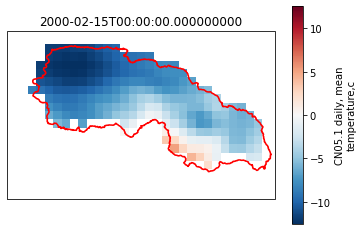

In [24]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([91, 99, 27, 32])   # setp region
ds_subs_mask['tm'][1].plot(x='lon',y='lat', ax=ax)
plt.title(ds_subs_mask['time'][id_date].values)
## 1. Tibeteau southeast boundary
shp_fea = cfeature.ShapelyFeature(Reader(path_setp_vec).geometries(), \
                      crs=ccrs.PlateCarree(), edgecolor='Red', linewidth=1.5, facecolor='none')
ax.add_feature(shp_fea, zorder=1)
